In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

In [59]:
hm = 6
window_dim = hm/2/4

velocity_scaling = 1
ventilation_scaling = velocity_scaling/(window_dim**2)

@utils.no_kwargs
@utils.dict_apply
def norm_vel(df):
    return df * velocity_scaling

@utils.no_kwargs
@utils.dict_apply
def norm_vent(df):
    return df * ventilation_scaling

@utils.no_kwargs
@utils.dict_apply
def abs_values(df):
    return df.abs()

@utils.no_kwargs
@utils.dict_apply
def flip_data(df):
    return -df


In [16]:
run = 18
qoisOutputed = ["mass_flux", "comp(u,0)"]
qois= ["mass_flux"]

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'

# probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed)
# probes.to_parquet(overwrite = True)

probes = probePost.Probes(probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type = "parquet")



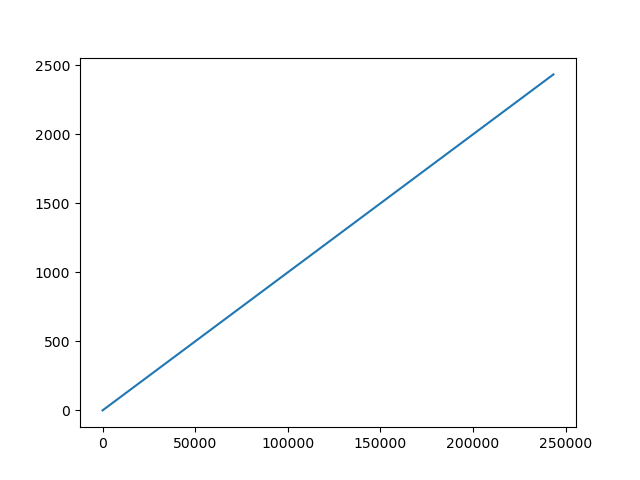

In [17]:
plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)
plt.show()

In [18]:
start = 150000
stop = -1
by = 1

(0.0, 2.45)

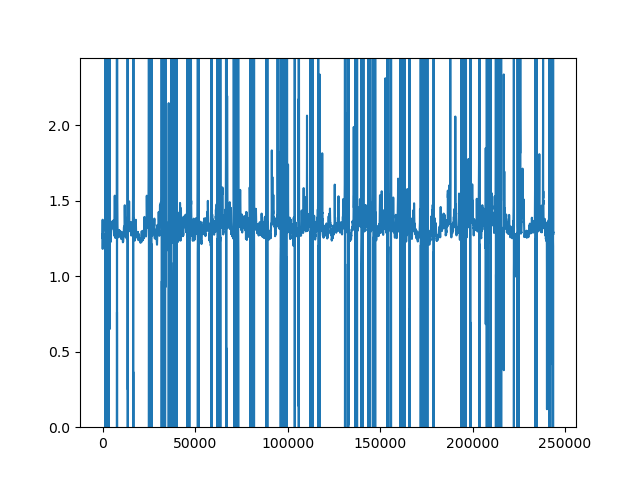

In [19]:
plt.figure()
foo_mass = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[0])].compute()
foo_u = probes.data[("xwindow_0-0_h_3-0_Bx", qoisOutputed[1])].compute()
foo_area = probes.areas["xwindow_0-0_h_3-0_Bx"]
plt.plot(foo_mass.values/foo_u.values)
plt.ylim(0,1.225*2)


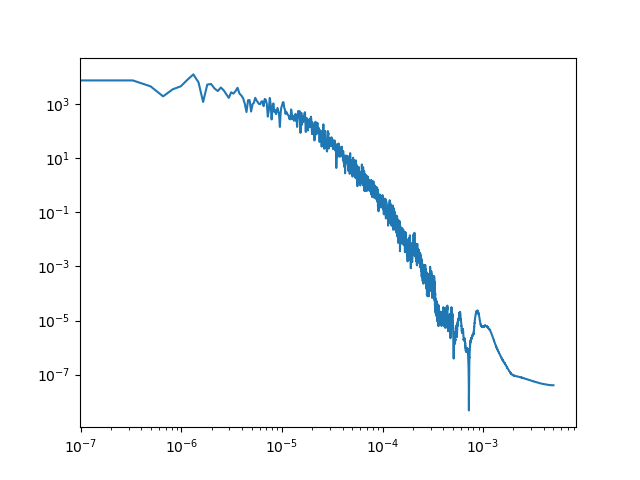

In [20]:
plt.figure()
N = len(foo_mass)
f, E = sp.signal.welch(foo_mass.values, fs = probes.dt, axis = 0, nperseg = N//4, scaling = 'density', detrend = 'constant') 
plt.loglog(f, E)

## X Flow


In [56]:
@utils.no_kwargs
def norm_norm_blocks(data_dict):
    return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bz" in name], -1)

# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "xwindow_" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_blocks],
#     parrallel=True
#     )

## mean statistics
x_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [probePost.time_average, norm_norm_blocks],
    parrallel=False
    )

## rms statistics
x_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [probePost.time_rms],
    parrallel=False
    )

## Net flow
x_net = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [abs_values, probePost.time_average],
    parrallel=False
    )

x_flowStats = pd.concat([x_mean, x_rms, x_net], axis = "index").T
x_flowStats.columns = ["mean", "rms", "net"]

processing data took 7 seconds
processing data took 7 seconds
processing data took 6 seconds


In [53]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows', bbox = "tight")

# x_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xmean.csv')
# x_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xrms.csv')
# x_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xnet.csv')

## Z Flow


In [57]:
@utils.no_kwargs
def norm_norm_windows(data_dict):
    return probePost.mul_names(data_dict, [name for name in probes.probe_names if "-1_h" in name], -1)

@utils.no_kwargs
def norm_norm_blocks(data_dict):
    return probePost.mul_names(data_dict, [name for name in probes.probe_names if "Bxz" in name or "Bx" in name], -1)

# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "zwindow" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_norm_windows, norm_norm_blocks],
#     parrallel=True
#     )

## mean statistics
z_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [probePost.time_average, norm_norm_windows, norm_norm_blocks],
    parrallel=False
    )

## rms statistics
z_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [probePost.time_rms],
    parrallel=False
    )

## Net flow
z_net = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [abs_values, probePost.time_average],
    parrallel=False
    )

z_flowStats = pd.concat([z_mean, z_rms, z_net], axis = "index").T
z_flowStats.columns = ["mean", "rms", "net"]

processing data took 19 seconds
processing data took 19 seconds
processing data took 17 seconds


In [55]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindows', bbox_inches = "tight")

# z_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zmean.csv')
# z_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zrms.csv')
# z_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/znet.csv')

## Y Flow


In [60]:
# (fig, ax) = probes.time_plots(
#     names = [name for name in  probes.probe_names if "skylight" in name], 
#     steps = probes.probe_steps[start:stop:by],
#     quants = qois,
#     plot_params = {
#         'stack span' : 'y',
#         'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
#         'xlabel' : 'time $[s]$',
#         'horizontal spacing' : probes.probe_times,
#         },
#     processing = [norm_vent, norm_norm_skylights],
#     parrallel=True
#     )

## mean statistics
y_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [probePost.time_average, flip_data],
    parrallel=False
    )

## rms statistics
y_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [probePost.time_rms],
    parrallel=False
    )

## Net flow
y_net = probes.statistics(
    names = [name for name in  probes.probe_names if "skylight" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [probePost.time_average, flip_data],
    parrallel=False
    )

y_flowStats = pd.concat([y_mean, y_rms, y_net], axis = "index").T
y_flowStats.columns = ["mean", "rms", "net"]

processing data took 3 seconds
processing data took 3 seconds
processing data took 3 seconds


In [57]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/ywindows')

# y_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ymean.csv')
# y_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/yrms.csv')
# y_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/ynet.csv')

## All Flow

In [58]:
flowStats = pd.concat([x_flowStats, y_flowStats, z_flowStats], axis = "index")

In [69]:
locs = probes.get_avg_locations()

In [60]:
areas = pd.Series(probes.areas)

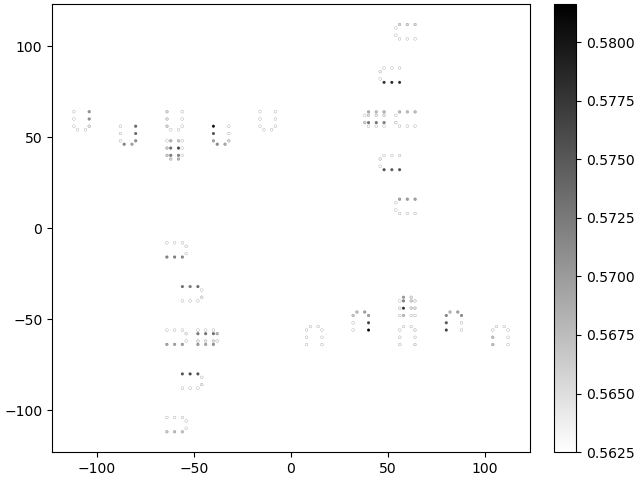

In [61]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=areas[flowStats.index], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

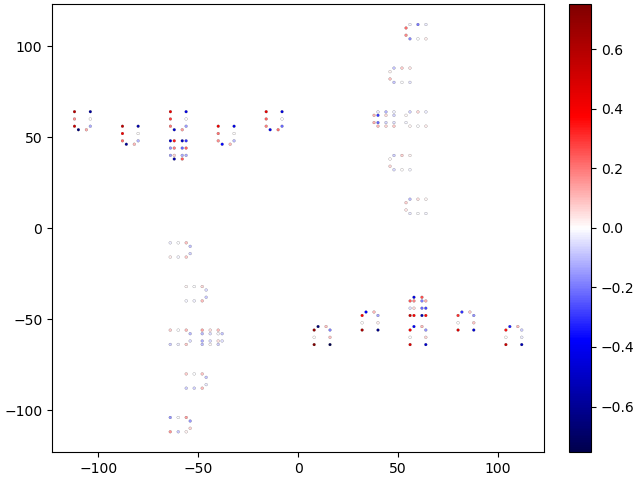

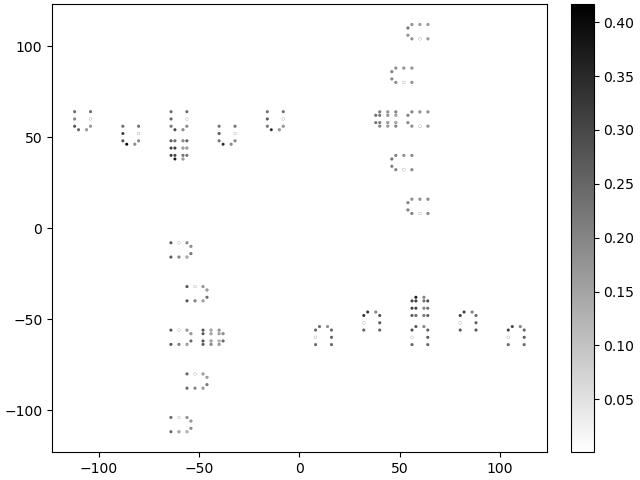

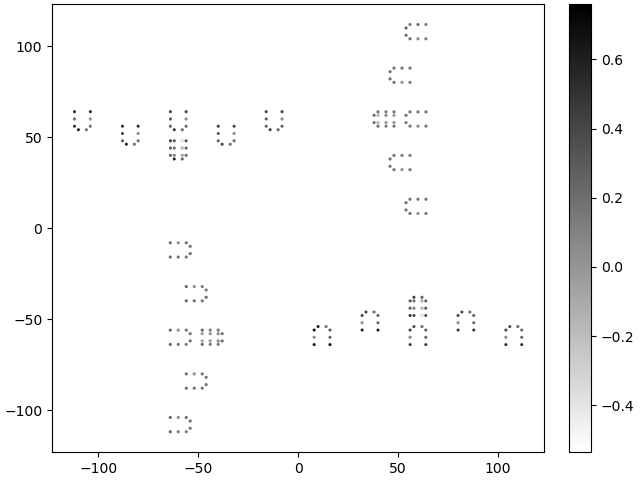

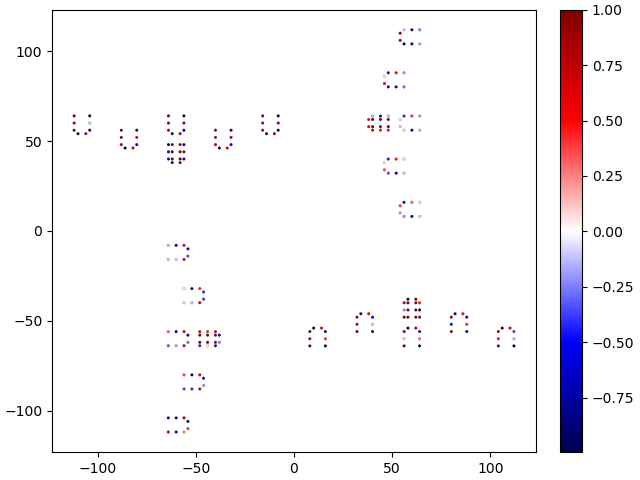

In [62]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=flowStats["rms"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=flowStats["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=flowStats["mean"]/flowStats["net"], cmap='seismic', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanOrmsInterior', bbox_inches="tight")

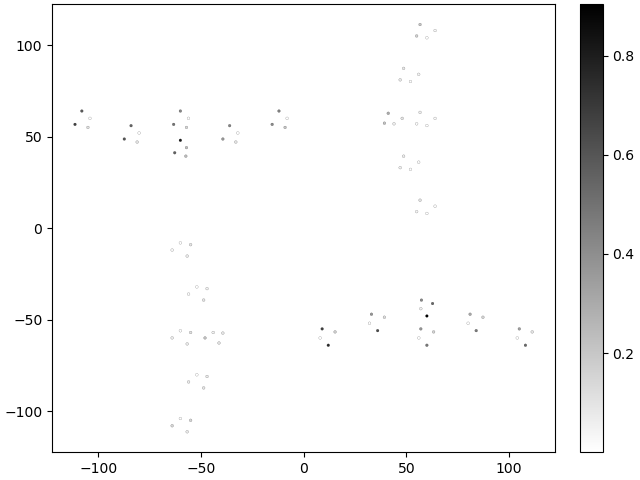

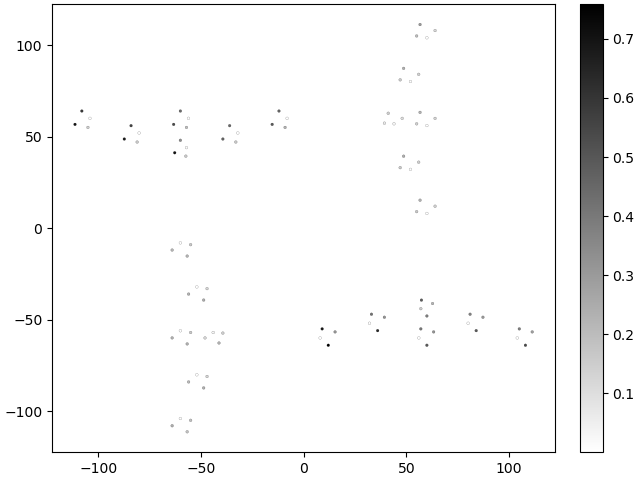

In [63]:
houses = ["h_3-0", "h_3-1", "h_3-2", "h_3-3", "h_3-4", "sl"]
blocks = ["", "Bx", "Bz", "Bxz"]

connectedWindows = {
    "corner": [
        "xwindow_0-0",
        "zwindow_0-0",
        "skylight_0-0"
    ],
    "single": [
        "zwindow_1-0",
        "skylight_1-0"
    ],
    "dual": [
        "xwindow_0-1",
        "zwindow_0-1",
        "zwindow_1-1",
        "skylight_0-1",
        "skylight_1-1"
    ],
    "cross": [
        "zwindow_2-0",
        "zwindow_2-1",
        "skylight_2-0",
        "skylight_2-1"
    ]
}
roomVentilation = {}
roomLocs = {}
for block in blocks:
    for house in houses:
        for room, windows in connectedWindows.items():
            netVent = 0
            meanVent = 0
            x = []
            y = []
            z = []
            for window in windows:
                if "skylight" in window and "sl" not in house:
                    continue
                if block == "":
                    windowKey = f"{window}_{house}"
                    roomKey = f"{room}_{house}"
                else:
                    windowKey = f"{window}_{house}_{block}"
                    roomKey = f"{room}_{house}_{block}"
                netVent += flowStats.loc[windowKey, "net"]
                meanVent += np.abs(flowStats.loc[windowKey, "mean"])
                x.append(locs.loc[windowKey, 'x'])
                y.append(locs.loc[windowKey, 'y'])
                z.append(locs.loc[windowKey, 'z'])
            netVent /= 2
            meanVent /= 2
            roomVentilation.update({roomKey : {"net" : netVent, "mean" : meanVent}})
            x = np.mean(x)
            y = np.mean(y)
            z = np.mean(z)
            roomLocs.update({roomKey : {'x' : x, 'y' : y, 'z' : z}})
                
roomVentilation = pd.DataFrame(roomVentilation).T  
roomLocs = pd.DataFrame(roomLocs).T 

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomLocs.loc[roomVentilation.index, 'x'], roomLocs.loc[roomVentilation.index, 'z'], s=4, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(roomLocs.loc[roomVentilation.index, 'x'], roomLocs.loc[roomVentilation.index, 'z'], s=4, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netRooms', bbox_inches="tight")

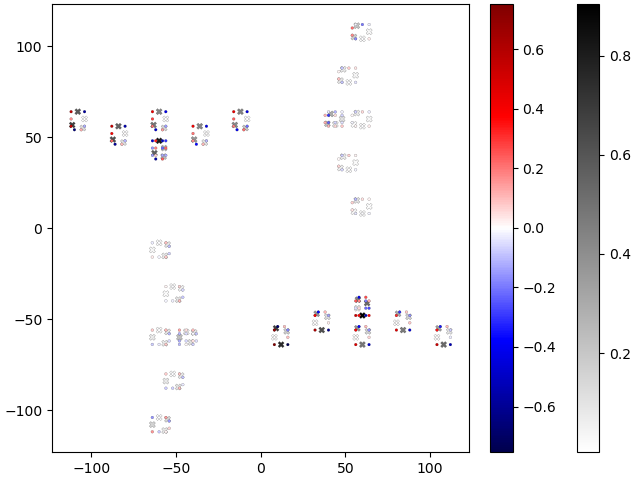

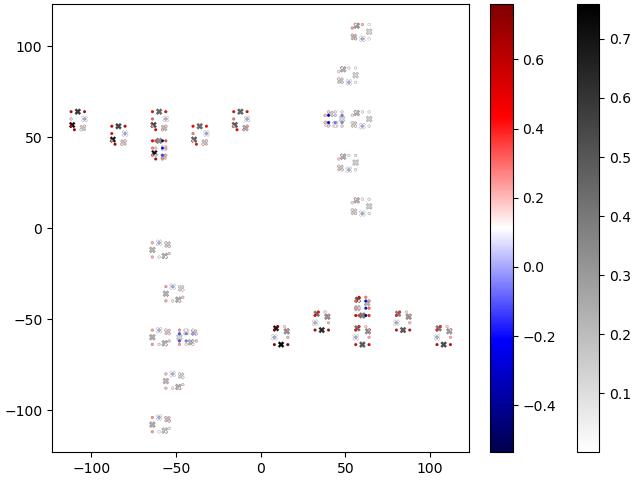

In [64]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomLocs.loc[roomVentilation.index, 'x'], roomLocs.loc[roomVentilation.index, 'z'], s=20, c=roomVentilation["mean"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=flowStats["mean"], cmap='seismic', edgecolors="black", linewidths=.1)
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanWindowsRooms', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im1=ax.scatter(roomLocs.loc[roomVentilation.index, 'x'], roomLocs.loc[roomVentilation.index, 'z'], s=20, c=roomVentilation["net"], cmap='binary', edgecolors="black", linewidths=.1, marker = 'X')
im2=ax.scatter(locs.loc[flowStats.index, 'x'], locs.loc[flowStats.index, 'z'], s=4, c=flowStats["net"], cmap='seismic', edgecolors="black", linewidths=.1)
fig.colorbar(im1)
fig.colorbar(im2)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/netWindowsRooms', bbox_inches="tight")

## Convergence

processing data took 11 seconds


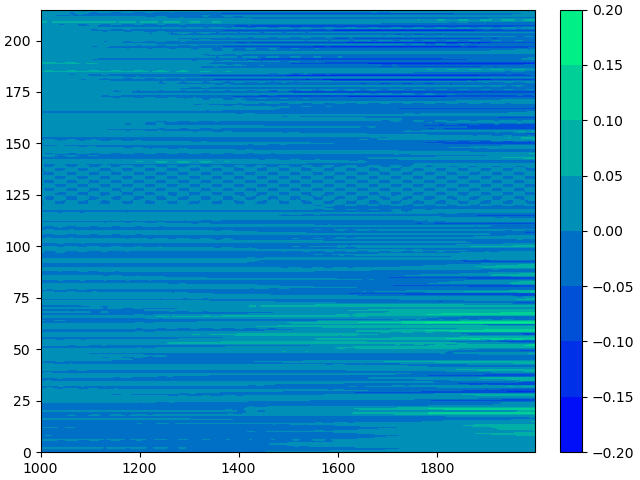

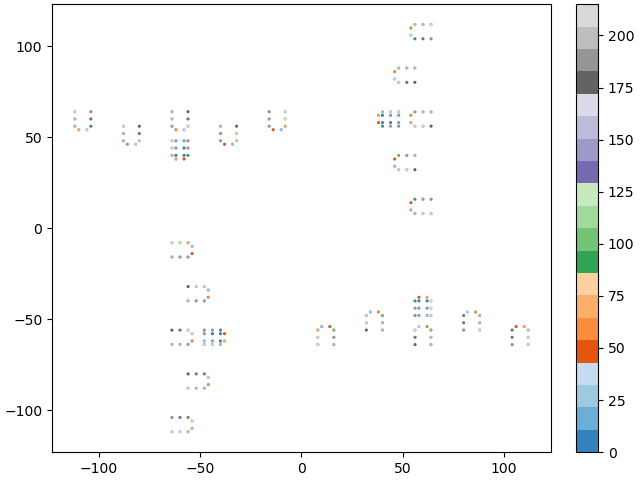

In [85]:
foo = probes.statistics(
    names = [name for name in probes.probe_names if "door" not in name], 
    steps = probes.probe_steps[start:2000:by],
    quants = qois,
    processing = [norm_vent],
    parrallel=False
    )

foo.shape

fig, ax = plt.subplots(constrained_layout = True)
xPlot = foo.index.values
yPlot = np.arange(len(foo.keys()))
im = ax.contourf(xPlot, yPlot, foo.T, cmap = "winter")
fig.colorbar(im)
# ax.set_yticks(yPlot)
# ax.set_yticklabels(foo.keys())

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourConvergence', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
im=ax.scatter(locs.loc[foo.keys(), 'x'], locs.loc[foo.keys(), 'z'], s=4, c=yPlot, cmap='tab20c', edgecolors="black", linewidths=.1)
fig.colorbar(im)
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/meanInterior', bbox_inches="tight")


In [83]:
stop = 2000

processing data took 13 seconds


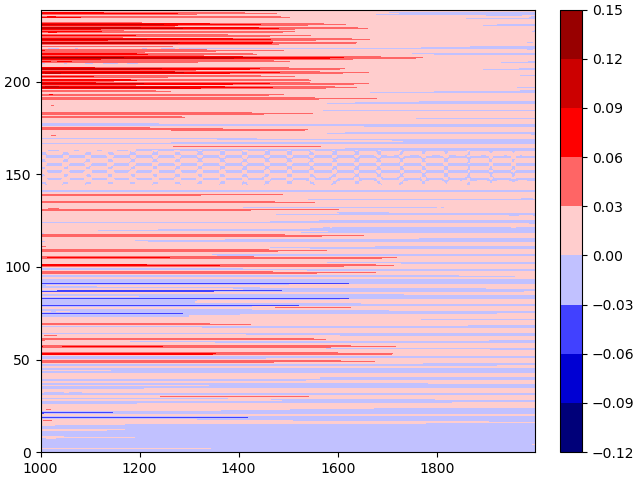

In [91]:
data = probes.statistics(
    names = probes.probe_names, 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    processing = [norm_vent, probePost.cumulative_mean, probePost.convergence],
    parrallel=True
    )

fig, ax = plt.subplots(constrained_layout = True)
xPlot = data.index.values
yPlot = np.arange(len(data.keys()))
im = ax.contourf(xPlot, yPlot, data.T, cmap = "seismic", norm = colors.TwoSlopeNorm(0))
fig.colorbar(im)

plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/convergence', bbox_inches="tight")

processing data took 55 seconds


/tmp/ipykernel_31098/2510566175.py:15: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/convergence', bbox_inches="tight")


processing data took 39 seconds


/tmp/ipykernel_31098/2510566175.py:31: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/cumulativeMean', bbox_inches="tight")
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.figure.savefig(buf, format='png', dpi='figure')


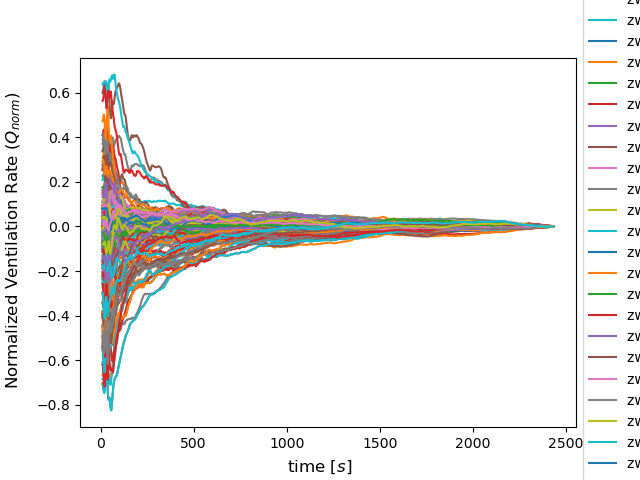

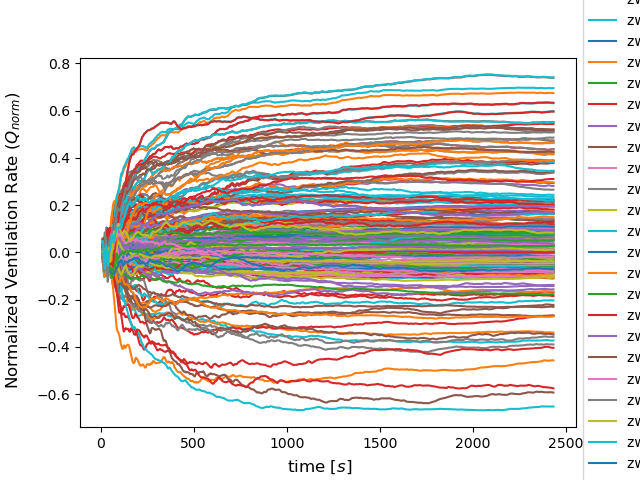

In [6]:
(fig, ax) = probes.time_plots(
    names = probes.probe_names, 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        'plot_every' : 100
        },
    processing = [norm_vent, probePost.cumulative_mean],
    parrallel=True
    )
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/cumulativeMean', bbox_inches="tight")

processing data took 40 seconds


/tmp/ipykernel_31098/2857674634.py:21: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/cumulativeMeanReverse', bbox_inches="tight")
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.figure.savefig(buf, format='png', dpi='figure')


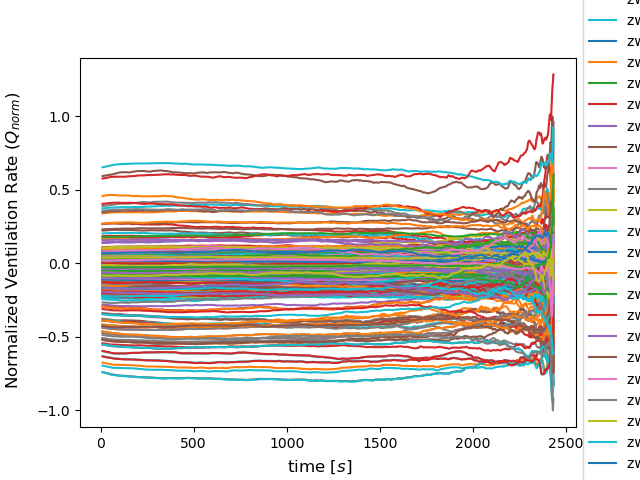

In [7]:
(fig, ax) = probes.time_plots(
    names = probes.probe_names, 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        'plot_every' : 100
        },
    processing = [
        norm_vent, 
        probePost.reverse, 
        probePost.cumulative_mean, 
        # probePost.convergence, 
        probePost.reverse
    ],
    parrallel=True
    )
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/cumulativeMeanReverse', bbox_inches="tight")

processing data took 18 seconds


/tmp/ipykernel_31098/3792140009.py:17: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rollingMean', bbox_inches="tight")
/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.figure.savefig(buf, format='png', dpi='figure')


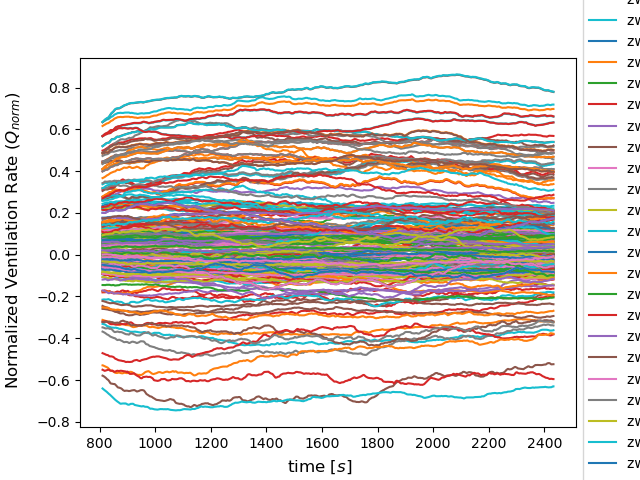

In [8]:
sma = probePost.quick_dict_apply(lambda data_df: data_df.rolling(80000).mean())

(fig, ax) = probes.time_plots(
    names = probes.probe_names, 
    steps = probes.probe_steps[start:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes.probe_times,
        'plot_every' : 100
        },
    processing = [norm_vent, sma],
    parrallel=True
    )
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/rollingMean', bbox_inches="tight")